# Linear regression and Kalman Filter

In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec

%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
# import FMNM.Kalman_filter as KF

## The dataset

The tickers are:
```
STOCKS: AAPL-> Apple, EXO.MI-> Exor (FIAT,Ferrari,etc), FB-> Facebook, GOOGL-> Google, UBS-> UBS,
INDECES: ^GSPC-> S&P500, ^IXIC-> Nasdaq, ^VIX-> VIX (Implied Volatility of S&P500).
BOND:^TNX-> Yield 10Y US.
```

In [3]:
filename = "../data/historical_data.csv"
data = pd.read_csv(filename, index_col="Date", parse_dates=True)
data.tail()

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-10-28,249.050003,62.939999,189.399994,1288.979980,11.95,3039.419922,8325.990234,1.853,13.11
2019-10-29,243.289993,62.160000,189.309998,1260.660034,12.08,3036.889893,8276.849609,1.835,13.20
2019-10-30,243.259995,65.019997,188.250000,1260.699951,11.84,3046.770020,8303.980469,1.798,12.33
2019-10-31,248.759995,68.720001,191.649994,1258.800049,11.77,3037.560059,8292.360352,1.691,13.22
2019-11-01,255.820007,69.459999,193.619995,1272.250000,11.96,3066.909912,8386.400391,1.728,12.30


## Data cleaning

In [4]:
data[data.isna().any(axis=1)].tail()

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-05-01,208.918625,NaN,193.029999,1173.319946,12.593584,2923.729980,8049.640137,2.511,14.80
2019-05-27,NaN,59.554962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-04,NaN,64.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-15,201.740005,NaN,182.589996,1169.319946,10.160000,2847.600098,7766.620117,1.529,21.18
2019-09-02,NaN,61.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
(data < 1e-2).any()

AAPL      False
EXO.MI    False
FB        False
GOOGL     False
UBS       False
^GSPC     False
^IXIC     False
^TNX      False
^VIX      False
dtype: bool

In [7]:
df = data[["GOOGL", "^GSPC"]]

In this analysis I use the following convention:

* If in one day there is only one value missing, I use the method 2) i.e. forward filling. I can justify this choice by saying that if there is no price, it means that the price hasn't changed.

* If in one day both values are missing, then I remove the entire line. (Probably the market was closed on that day)

In [8]:
history_len = 1000  # lenght of the time series
df.sort_index(inplace=True, ascending=True)  # not necessary in general, but useful
df = df.dropna(axis=1, how="all")  # drops columns with all NaNs
df = df.dropna(axis=0, how="all")  # drops rows with at least one NaN
df = df[-history_len:]
df = df.ffill()  # Forward fill
print("Are there still some NaNs? ")
df.isnull().any()

Are there still some NaNs? 


GOOGL    False
^GSPC    False
dtype: bool

In [9]:
returns = "log-returns"

if returns == "log-returns":
    ret = np.log(df / df.shift())[1:]
elif returns == "linear-returns":
    ret = df.pct_change()[1:]
elif returns == "total-returns":
    ret = df / df.shift()[1:]

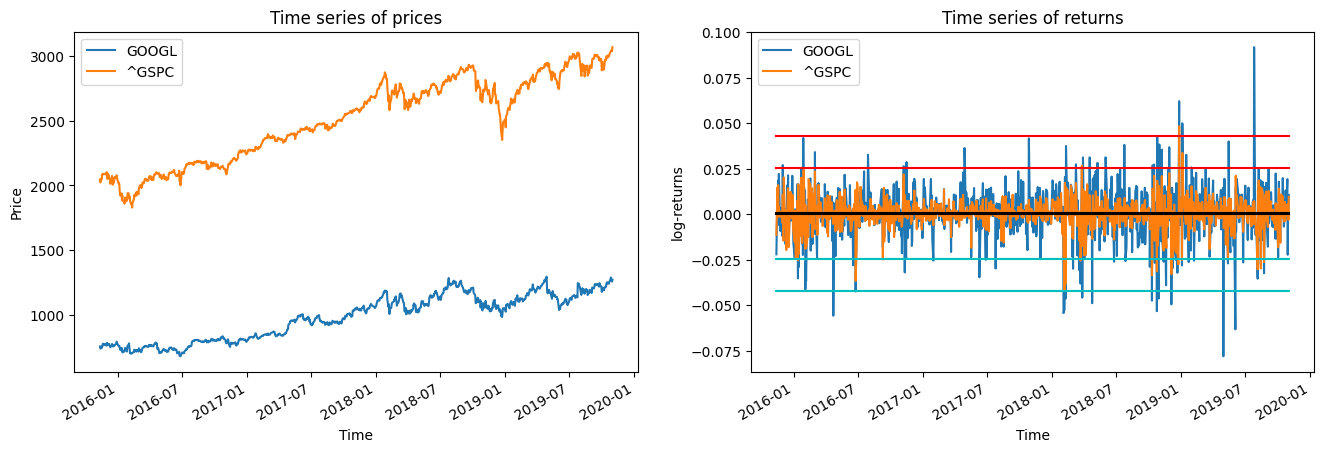

In [11]:
# Plot and check the outliers

NOSD = 3  # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns")
ax2.set_xlabel("Time")
ax2.set_ylabel(returns)
ax2.plot(ret.index, len(ret) * [mu], color="k")
ax2.plot(ret.index, len(ret) * [mu + NOSD * sig], color="red")
ax2.plot(ret.index, len(ret) * [mu - NOSD * sig], color="c")
plt.show()

In [12]:
median = ret.median()
MAD = ret.apply(ss.median_abs_deviation)
sig_robust = MAD * 1.4826
print("STD DEV: \n", sig)
print("")
print("Robust STD DEV: \n", sig_robust)

STD DEV: 
 GOOGL    0.014242
^GSPC    0.008324
dtype: float64

Robust STD DEV: 
 GOOGL    0.010268
^GSPC    0.005255
dtype: float64


In [13]:
outliers = ret[ret[np.abs(ret - median) > NOSD * sig_robust].any(axis=1)]  # outliers
outliers

,GOOGL,^GSPC
Date,,
2015-12-04,0.014230,0.020318
2015-12-11,-0.012738,-0.019614
2015-12-18,-0.017005,-0.017957
2016-01-04,-0.024158,-0.015422
2016-01-07,-0.024436,-0.023986
...,...,...
2019-08-08,0.025424,0.018588
2019-08-14,-0.027516,-0.029730
2019-08-23,-0.032360,-0.026289


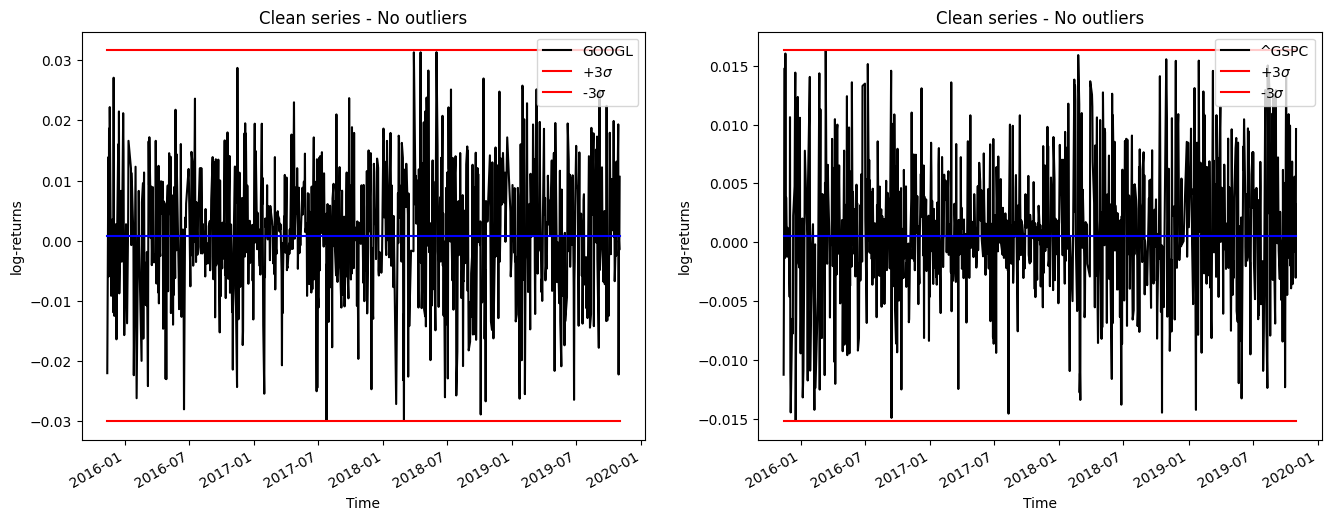

In [23]:
dret = ret.drop(outliers.index)  # series of returns without outliers
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for ax, col in zip([ax1, ax2], dret.columns):
    dret[col].plot(ax=ax, color='k')
    ax.set_title("Clean series - No outliers")
    ax.set_xlabel("Time")
    ax.set_ylabel(returns)
    ax.plot(dret.index, len(dret) * [median[col]], color="blue")
    ax.plot(dret.index, len(dret) * [median[col] + NOSD * sig_robust[col]], color="red", label="+3$\sigma$")
    ax.plot(dret.index, len(dret) * [median[col] - NOSD * sig_robust[col]], color="red", label="-3$\sigma$")
    ax.legend(loc="upper right")
plt.show()

In [24]:
print(
    "We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(
        len(ret), len(dret)
    )
)

We have reduced the initial DIRTY series of returns of size 999 to the new CLEAN series of size 911.


## Kalman regression model

In [25]:
### Training set

Y = dret.columns[0]
X = dret.columns[1]

training_size = 250
ret_train = dret.iloc[:training_size]
ret_test = dret.iloc[training_size:]

beta_tr, alpha_tr, _, _, _ = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)  # a possible initial guess for var_eps
print("In the training set the OLS estimators of")
print("alpha_tr = ", alpha_tr)
print("beta_tr = ", beta_tr)
print("var_eps = ", var_eps_ols)

In the training set the OLS estimators of
alpha_tr =  0.00022764404115736565
beta_tr =  0.9751772551661361
var_eps =  6.286775484858259e-05


In [26]:
rolling_window = 50
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range(len(ret_test)):
    ret_temp = ret.iloc[1 + i + training_size - rolling_window : 1 + i + training_size]
    beta_temp, alpha_temp, _, _, std_err_temp = ss.linregress(ret_temp[X], ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

In [27]:

x = np.array([[alpha_tr], [beta_tr]])  # initial mean of alpha and beta
P = 0.1 * np.eye(2)  # initial covariance of alpha and beta
eta_alpha = 0.0000001  # variance of the alpha process
eta_beta = 0.01  # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])  # process covariance matrix
R = np.array([[var_eps_ols]])  # variance for the measurement - 1 dim
F = np.eye(2)  # transition matrix
H = np.vstack((np.ones(len(ret_test)), ret_test[X].values)).T  # measurement matrix

## Implementation of the Kalman filter for $\alpha$ and $\beta$ 

In [28]:
x = np.array([[alpha_tr], [beta_tr]])  # initial mean of alpha and beta
P = 0.1 * np.eye(2)  # initial covariance of alpha and beta
eta_alpha = 0.0000001  # variance of the alpha process
eta_beta = 0.01  # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])  # process covariance matrix
R = np.array([[var_eps_ols]])  # variance for the measurement - 1 dim
F = np.eye(2)  # transition matrix
H = np.vstack((np.ones(len(ret_test)), ret_test[X].values)).T  # measurement matrix

In [29]:
alphas, betas = np.full(len(ret_test), np.NaN), np.full(len(ret_test), np.NaN)
for i, y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q

    # update
    S = (H[None, i] @ P @ H[None, i].T) + R  # Here S is a scalar
    K = (P @ H[None, i].T) @ inv(S)
    r = y - H[None, i] @ x  # residuals
    x = x + K @ r  # v is a scalar.
    P = P - K @ H[None, i] @ P  # K @ H[None,i] is an outer product

    alphas[i] = x[0, 0]
    betas[i] = x[1, 0]

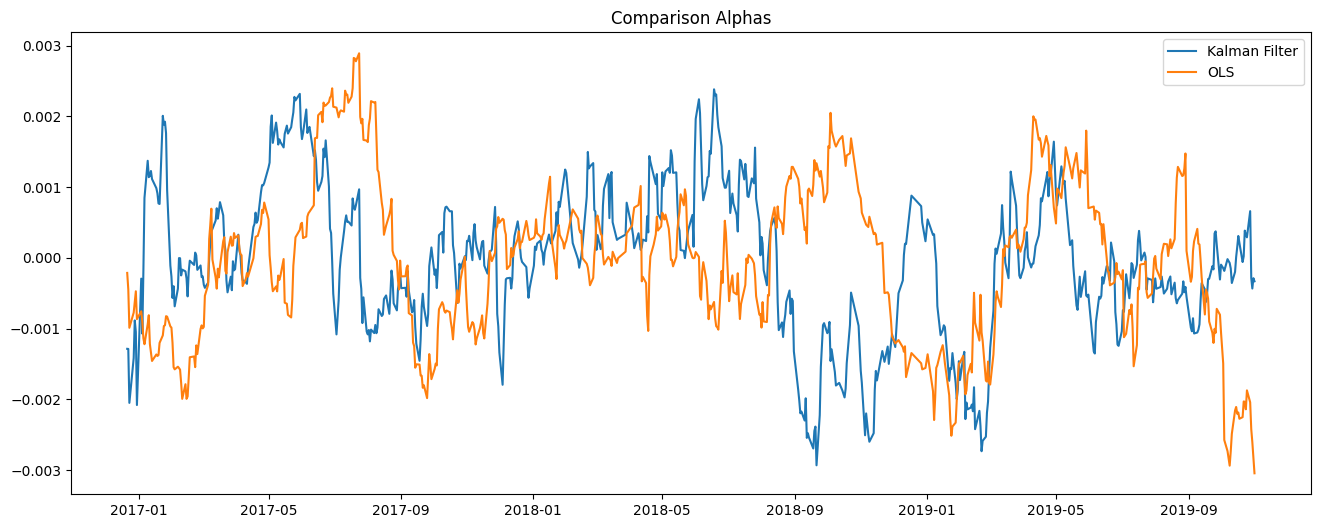

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, alphas, label="Kalman Filter")
plt.plot(ret_test["ols_alpha"], label="OLS")
plt.legend()
plt.title("Comparison Alphas")
plt.show()

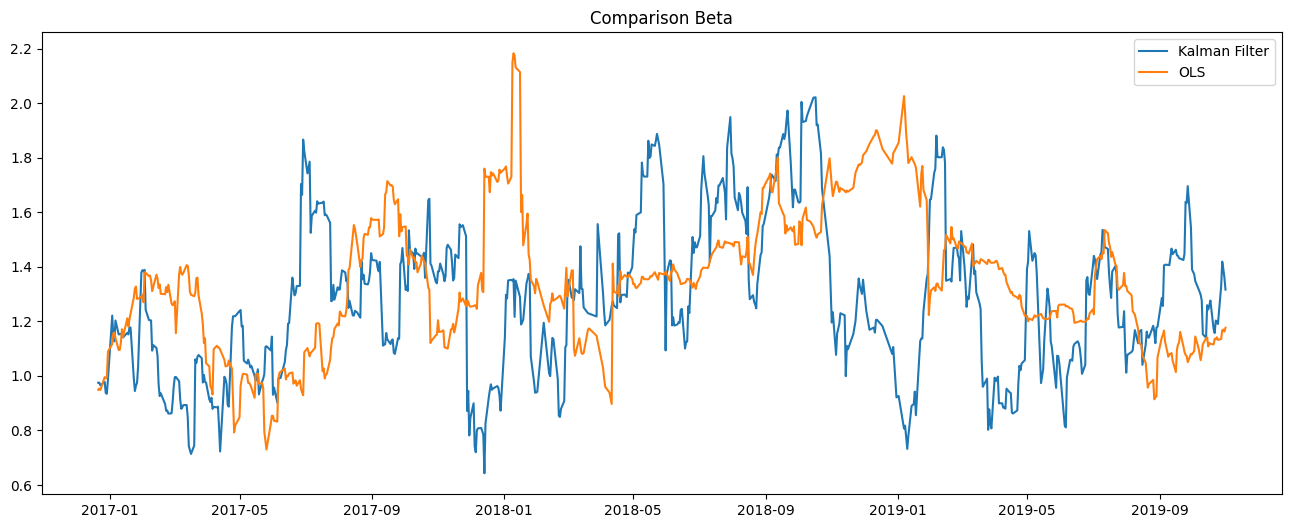

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, betas, label="Kalman Filter")
plt.plot(ret_test["ols_beta"], label="OLS")
plt.legend()
plt.title("Comparison Beta")
plt.show()

### Comments
* Looking at the two plots above, we can see that the curves are very similar. An important thing to notice is that the OLS is shiftet on the right i.e. **OLS is delayed!** The Kalman estimates can reflect much better the true (spot) value of the state.
* The filter is very robust with respect to initial guesses. If, for instance, you try to set P = 100 * np.eye(2), you will see that it will converge quickly to a "reasonable" value.
* In the matrix H[None,i] I had to use the keyword None in order to maintain the information of the array dimensions, H[None,0].shape = (1,2). This is a bad feature of the language. Python automatically removes dimensions of a subarray i.e. H[0].shape = (2,).
* $K @ H[None,i]$ is an outer product of dimension $(2,2) = (2,1) \times (1, 2)$
* I used inv(S) to compute the inverse of S. In the notebook A1 I repeated many times that inverting matrices is bad. But for the Kalman filter, since usually S has small rank (here S is a scalar), we can make an exception :)

# Resources

* https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/5.1%20Linear%20regression%20-%20Kalman%20filter.ipynb
* Analysis of Financial Time Series’ book